## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Data Load

In [2]:
#import dataset
dataset = pd.read_csv('/content/test.csv')

In [3]:
# View first 5 rows
print("🔹 Head of dataset:")
print(dataset.head())

🔹 Head of dataset:
   Age  Grade  Gender      Race  SES_Quartile ParentalEducation SchoolType  \
0   15     10  Female     White             1                HS     Public   
1   16     11  Female  Hispanic             1               <HS    Private   
2   17     12  Female     Black             2                HS     Public   
3   16     11  Female     White             2                HS     Public   
4   16     11    Male     Black             3        Bachelors+     Public   

  Locale  TestScore_Math  TestScore_Reading  ...       GPA  AttendanceRate  \
0   City       72.346053          62.217134  ...  2.521745        0.868836   
1   City       77.889157          72.748030  ...  3.275626        0.909595   
2  Rural       72.966587          65.585472  ...  2.974137        0.870952   
3   Town       96.674049          88.035852  ...  3.676590        1.000000   
4  Rural       81.989270          77.485372  ...  2.255014        0.897957   

   StudyHours  InternetAccess  Extracurricu

In [4]:
# Show dataset info
print("\n🔹 Dataset Information:")
print(dataset.info())


🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999997 entries, 0 to 999996
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                999997 non-null  int64  
 1   Grade              999997 non-null  int64  
 2   Gender             999997 non-null  object 
 3   Race               999997 non-null  object 
 4   SES_Quartile       999997 non-null  int64  
 5   ParentalEducation  999997 non-null  object 
 6   SchoolType         999997 non-null  object 
 7   Locale             999997 non-null  object 
 8   TestScore_Math     999997 non-null  float64
 9   TestScore_Reading  999997 non-null  float64
 10  TestScore_Science  999997 non-null  float64
 11  GPA                999997 non-null  float64
 12  AttendanceRate     999997 non-null  float64
 13  StudyHours         999997 non-null  float64
 14  InternetAccess     999997 non-null  int64  
 15  Extracurricular    999997 n

In [5]:
print('TestScore_Math',dataset['TestScore_Math'].mean())
print('TestScore_Reading',dataset['TestScore_Reading'].mean())
print('TestScore_Science',dataset['TestScore_Science'].mean())
print('AttendanceRate',dataset['AttendanceRate'].mean())

TestScore_Math 74.98007274984671
TestScore_Reading 74.97816767641696
TestScore_Science 74.98395452779016
AttendanceRate 0.8995617045012847


In [6]:
dataset['TestScore_Math']

,TestScore_Math
0,72.346053
1,77.889157
2,72.966587
3,96.674049
4,81.989270
...,...
999992,85.027753
999993,63.746863
999994,46.145953
999995,62.400489


In [7]:
# target variable
dataset['Risk'] = (dataset['GPA'] < 2.5).astype(int)
print(dataset['Risk'].value_counts())

Risk
0    857753
1    142244
Name: count, dtype: int64


In [8]:
# 1. Missing Values
print("\n🔹 Missing Values:")
print(dataset.isnull().sum())

# Option 1: Fill missing numerical values with mean
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].mean())

# Option 2: Fill missing categorical values with mode
categorical_cols = dataset.select_dtypes(include=['object']).columns
dataset[categorical_cols] = dataset[categorical_cols].fillna(dataset[categorical_cols].mode().iloc[0])

print("\n✅ After Filling Missing Values:")
print(dataset.isnull().sum())


🔹 Missing Values:
Age                  0
Grade                0
Gender               0
Race                 0
SES_Quartile         0
ParentalEducation    0
SchoolType           0
Locale               0
TestScore_Math       0
TestScore_Reading    0
TestScore_Science    0
GPA                  0
AttendanceRate       0
StudyHours           0
InternetAccess       0
Extracurricular      0
PartTimeJob          0
ParentSupport        0
Romantic             0
FreeTime             0
GoOut                0
Risk                 0
dtype: int64

✅ After Filling Missing Values:
Age                  0
Grade                0
Gender               0
Race                 0
SES_Quartile         0
ParentalEducation    0
SchoolType           0
Locale               0
TestScore_Math       0
TestScore_Reading    0
TestScore_Science    0
GPA                  0
AttendanceRate       0
StudyHours           0
InternetAccess       0
Extracurricular      0
PartTimeJob          0
ParentSupport        0
Romantic       

In [9]:
# 2. Outlier Detection and Removal (using Z-score method)
print("\n🔹 Removing Outliers:")

from scipy import stats

outlier_cols = ['AttendanceRate', 'StudyHours']
z = np.abs(stats.zscore(dataset[outlier_cols]))
dataset = dataset[(z < 3).all(axis=1)]
print("After removing outliers:", dataset.shape)



🔹 Removing Outliers:
After removing outliers: (997051, 22)


In [10]:
# 3. Data Tranformation
# Re-select numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

excluded_cols = ['Risk','GPA','InternetAccess','Extracurricular','PartTimeJob','Romantic']
continuous_cols = [col for col in numeric_cols if col not in excluded_cols]

# Step 0: Save original skewness
original_skewness = dataset[continuous_cols].skew()

# Step 1: Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
dataset[continuous_cols] = pt.fit_transform(dataset[continuous_cols])

# Step 2: Skewness comparison
transformed_skewness = dataset[continuous_cols].skew()
skew_df = pd.DataFrame({
    'Before': original_skewness,
    'After': transformed_skewness
})
print("\n✅ Skewness Comparison (Before vs After Transformation):")
print(skew_df)


✅ Skewness Comparison (Before vs After Transformation):
                     Before     After
Age                0.000954 -0.025346
Grade             -0.362181 -0.184947
SES_Quartile      -0.000461 -0.105767
TestScore_Math    -0.021147 -0.007184
TestScore_Reading -0.016545 -0.007071
TestScore_Science -0.020306 -0.006909
AttendanceRate    -0.076675 -0.006439
StudyHours        -0.020501 -0.009735
ParentSupport      0.312657  0.312657
FreeTime          -0.002832 -0.041953
GoOut              0.522486  0.006580


In [11]:
# 4. Data Standardization
scaler = StandardScaler()
dataset[continuous_cols] = scaler.fit_transform(dataset[continuous_cols])

# Step 4: Display mean and standard deviation to confirm standardization
print("\n🔹 Summary After Standardization (Mean \u2248 0, Std \u2248 1):")
print(dataset[continuous_cols].describe().loc[['mean', 'std']])


🔹 Summary After Standardization (Mean ≈ 0, Std ≈ 1):
               Age         Grade  SES_Quartile  TestScore_Math  \
mean  1.970462e-17 -3.940923e-18 -3.092876e-17    1.425289e-17   
std   1.000001e+00  1.000001e+00  1.000001e+00    1.000001e+00   

      TestScore_Reading  TestScore_Science  AttendanceRate    StudyHours  \
mean      -1.339771e-17       3.340877e-17    9.207365e-18  1.516507e-17   
std        1.000001e+00       1.000001e+00    1.000001e+00  1.000001e+00   

      ParentSupport      FreeTime         GoOut  
mean  -5.290671e-17  1.798714e-17  3.050118e-18  
std    1.000001e+00  1.000001e+00  1.000001e+00  


In [12]:
# 5. Data Normalization
scaler_norm = MinMaxScaler()
dataset[continuous_cols] = scaler_norm.fit_transform(dataset[continuous_cols])

# Step 4: Preview normalized data
print("\n✅ Normalized Data (First 5 Rows):")
print(dataset[continuous_cols].head())

# Check the range after normalization
print("\n🔍 Normalized Feature Ranges:")
print(dataset[continuous_cols].agg(['min', 'max']))


✅ Normalized Data (First 5 Rows):
        Age     Grade  SES_Quartile  TestScore_Math  TestScore_Reading  \
0  0.256808  0.263418      0.000000        0.584552           0.438469   
1  0.508844  0.593673      0.000000        0.667410           0.594279   
2  0.756469  1.000000      0.368011        0.593816           0.488237   
3  0.508844  0.593673      0.368011        0.949777           0.821479   
4  0.508844  0.593673      0.697109        0.728841           0.664563   

   TestScore_Science  AttendanceRate  StudyHours  ParentSupport  FreeTime  \
0           0.589223        0.445164    0.149917            1.0  0.508419   
1           0.639119        0.613016    0.571894            0.0  0.508419   
2           0.515057        0.453775    0.541015            0.0  0.508419   
3           1.000000        1.000000    0.519041            0.0  0.755800   
4           0.584791        0.564670    0.408670            1.0  0.755800   

      GoOut  
0  0.638755  
1  0.000000  
2  0.638755  
3

In [13]:
# Step 6: Encode Categorical Variables (if any)
print("\n🔹 Encoding Categorical Variables:")

# Identify object or category columns
cat_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"🧾 Categorical columns to encode: {cat_cols}")

# Apply one-hot encoding to these columns (drop_first=True to avoid multicollinearity)
dataset = pd.get_dummies(dataset, columns=cat_cols, drop_first=True)

# Final check
print("✅ Final Dataset Shape after encoding:", dataset.shape)


🔹 Encoding Categorical Variables:
🧾 Categorical columns to encode: ['Gender', 'Race', 'ParentalEducation', 'SchoolType', 'Locale']
✅ Final Dataset Shape after encoding: (997051, 30)


## 4.4 Data Understanding

### 4.4.1 Variables Overview

Below is the explanation of each variable in the dataset:

| Variable | Description | Type |
|---------|-------------|------|
| Age | Student’s age | Numerical |
| Grade | Academic grade level (9–12) | Ordinal |
| Gender | Male / Female | Categorical |
| Race | Ethnic background | Categorical |
| SES_Quartile | Socioeconomic status quartile | Ordinal |
| ParentalEducation | Highest parent education level | Categorical |
| SchoolType | Public / Private | Categorical |
| Locale | Urban / Suburban / Rural | Categorical |
| TestScore_Math | Math test score | Numerical |
| TestScore_Reading | Reading test score | Numerical |
| TestScore_Science | Science test score | Numerical |
| GPA | Grade Point Average | Numerical |
| AttendanceRate | Attendance % | Numerical |
| StudyHours | Study hours per week | Numerical |
| InternetAccess | 1 = Yes, 0 = No | Binary |
| Extracurricular | 1 = Yes, 0 = No | Binary |
| PartTimeJob | 1 = Yes, 0 = No | Binary |
| ParentSupport | Level of support (0–1) | Numerical |
| Romantic | 1 = In relationship | Binary |
| FreeTime | Free time score (1–5) | Ordinal |
| GoOut | Going-out frequency (1–5) | Ordinal |


### 4.4.2 Observations

- The dataset contains information related to **student demographics**, **academic performance**, and **lifestyle behaviours**.
- No missing values remain after preprocessing.
- Outliers were removed using Z-score filtering.
- Several variables show skewness before transformation.
- Correlation among test scores and GPA appears strong, suggesting academic-related predictors.
- SES and parental education show moderate influence on GPA.
- Behavioural variables such as `GoOut`, `FreeTime`, and `StudyHours` appear less correlated.


### 4.4.3 Histogram, KDE & Boxplots

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


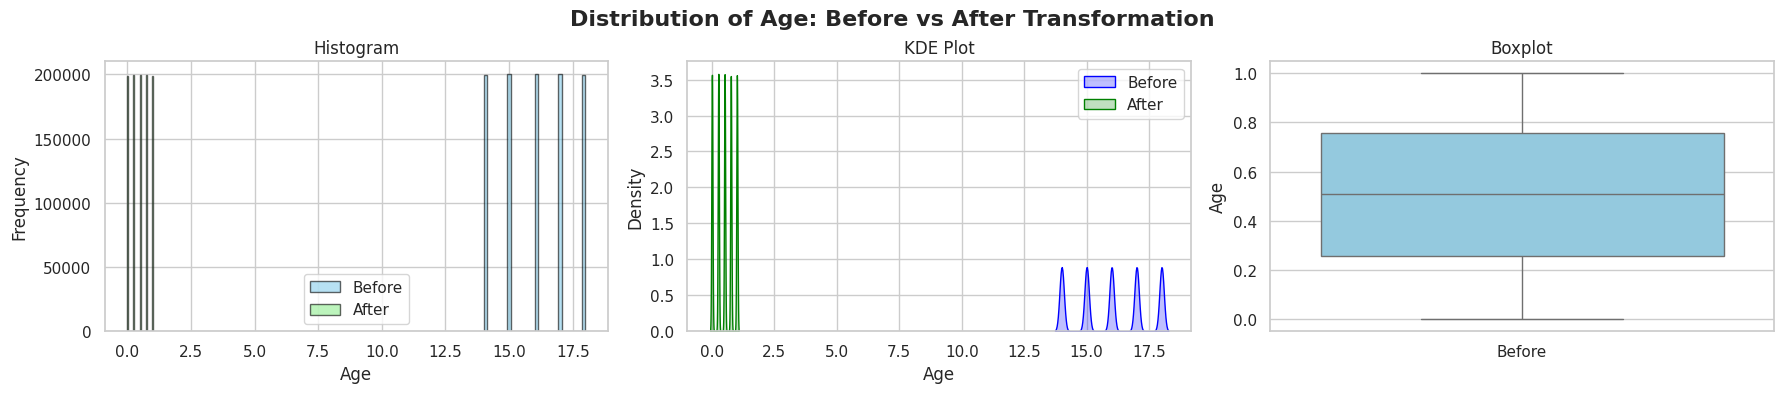

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


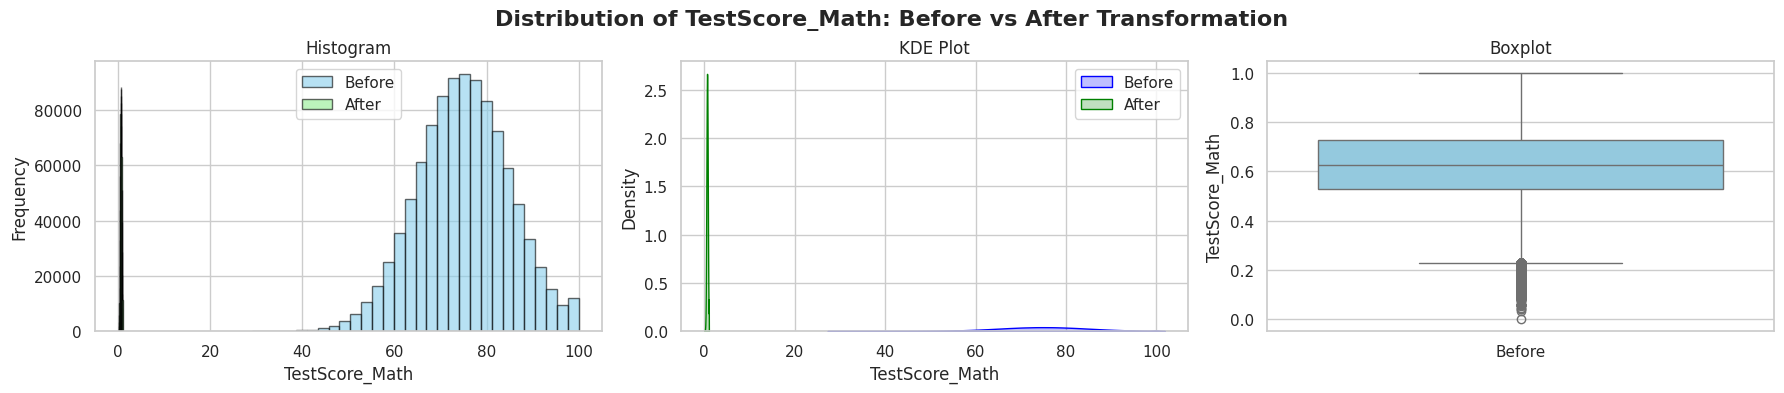

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


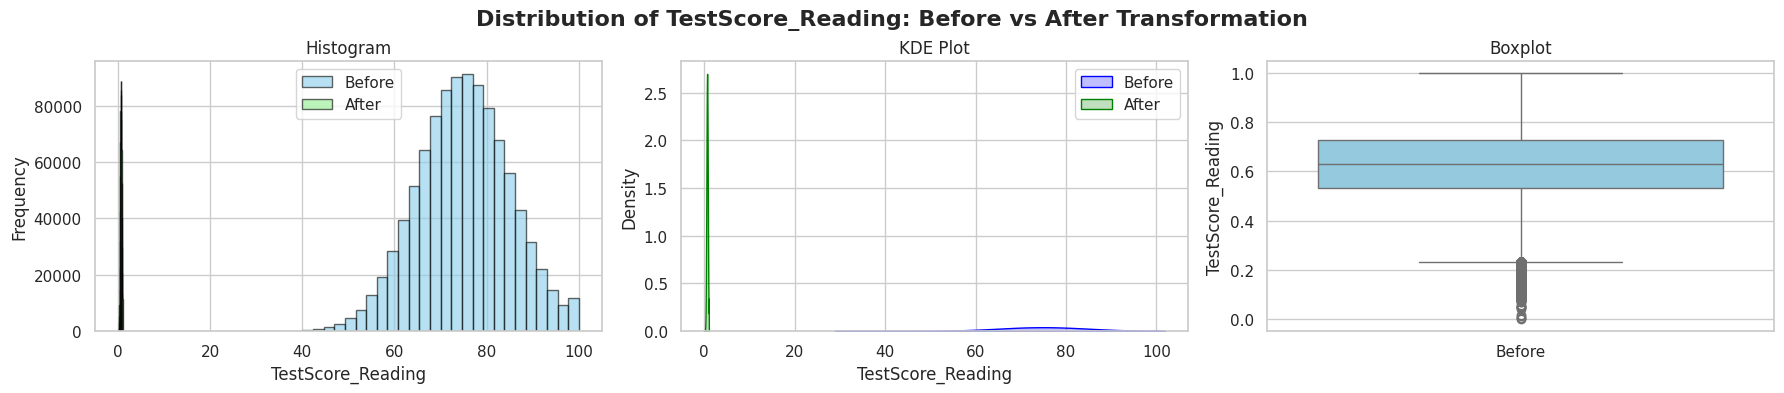

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


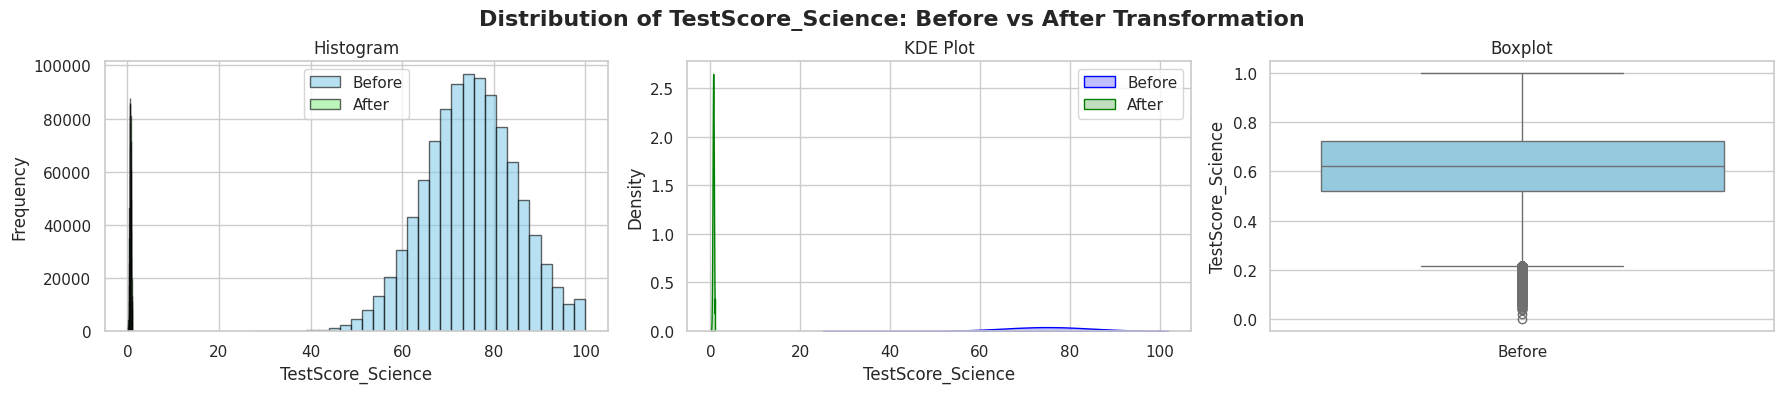

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


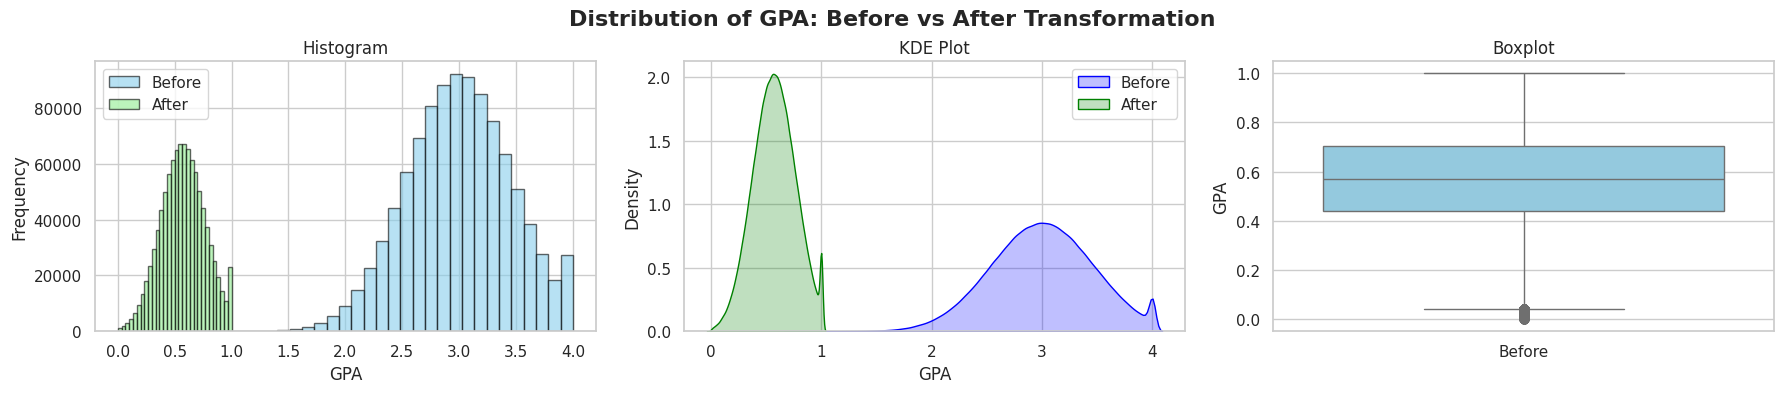

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


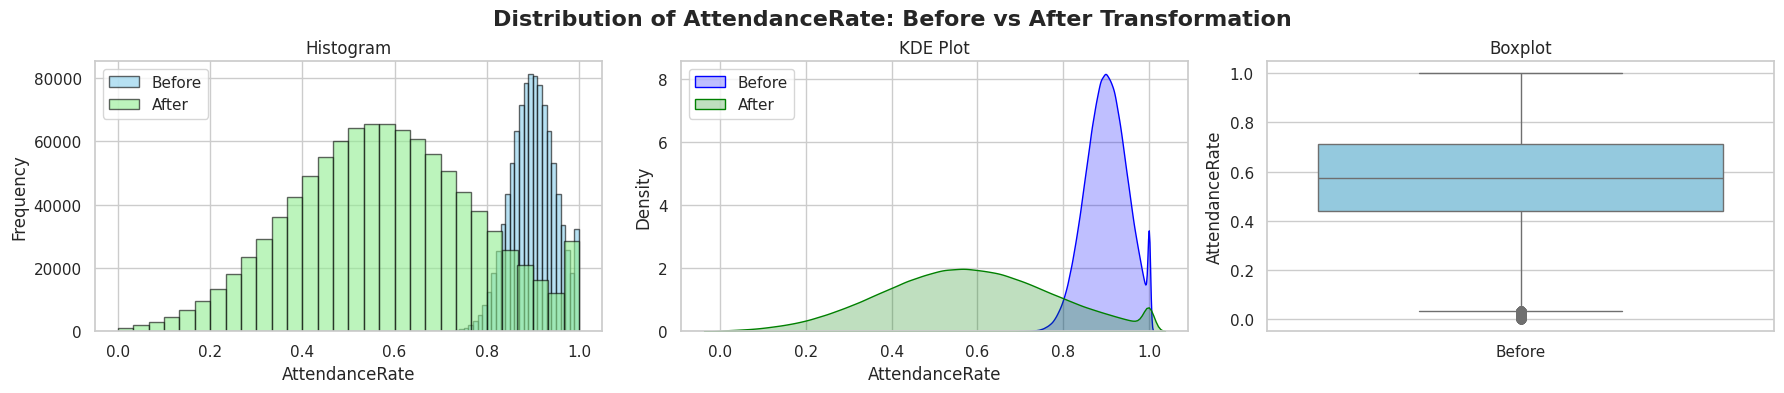

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


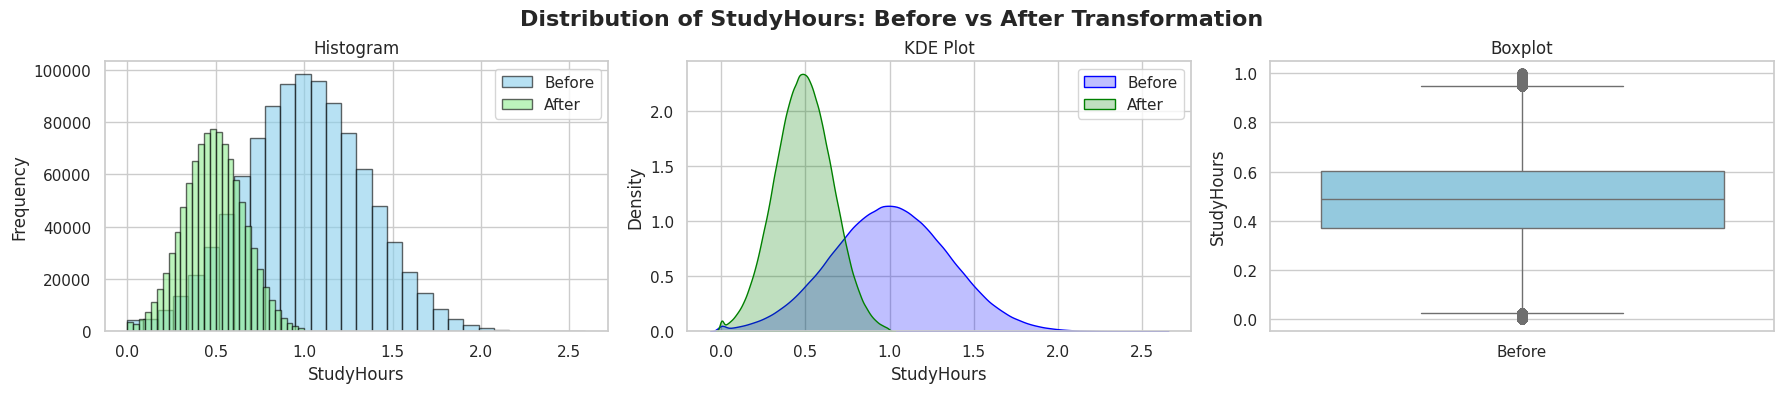

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


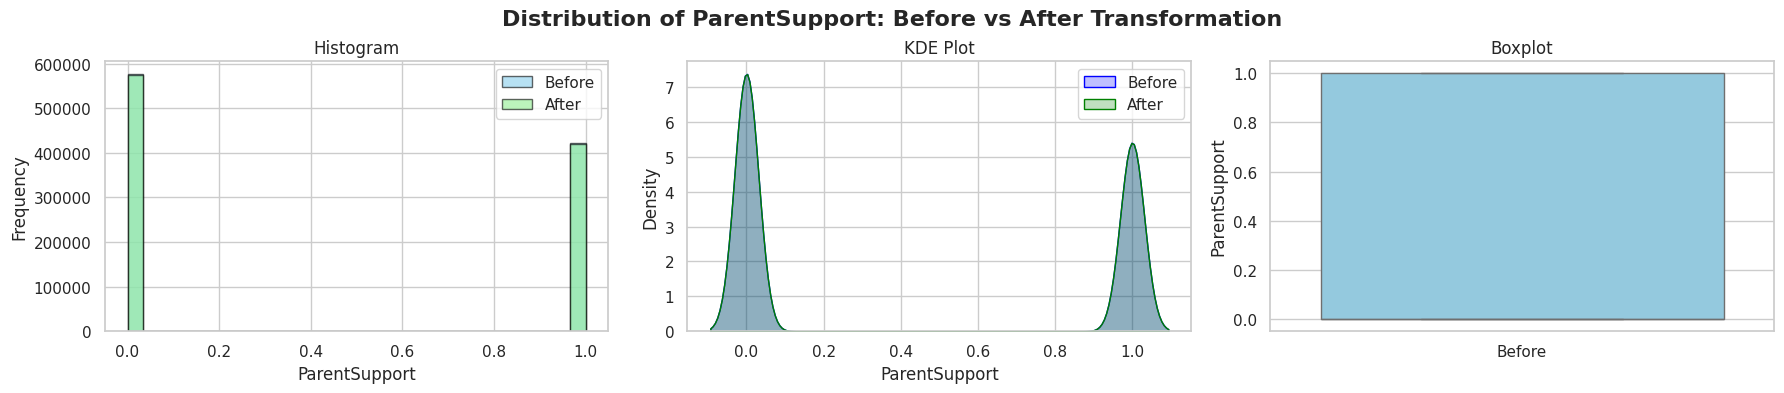

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


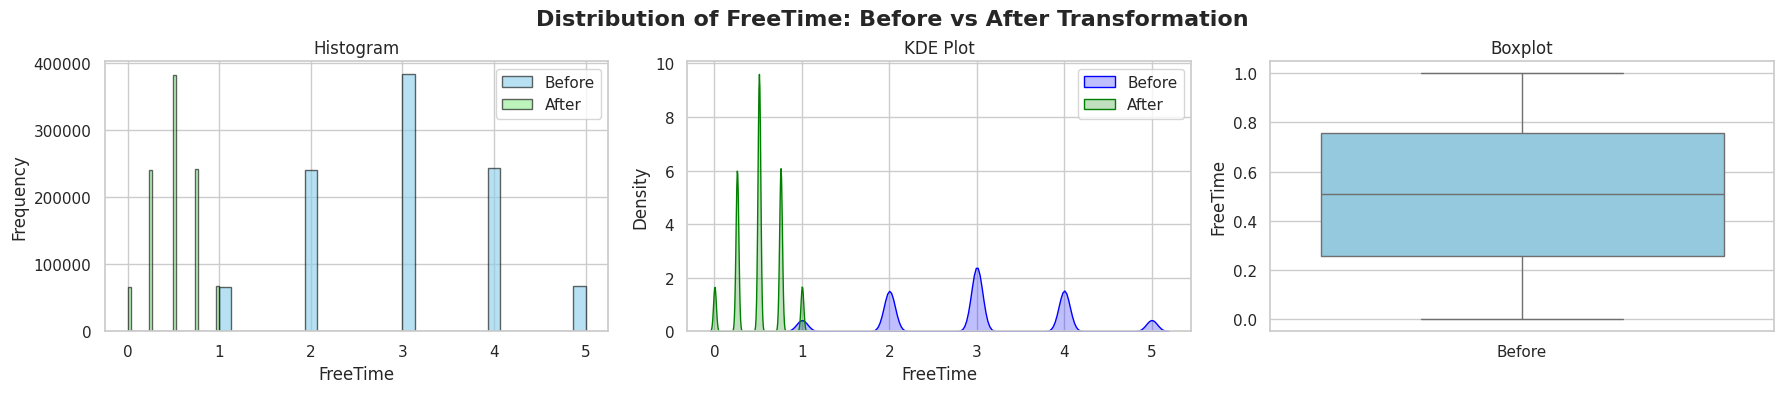

/tmp/ipython-input-2454834148.py:37: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
/tmp/ipython-input-2454834148.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["Before", "After"])


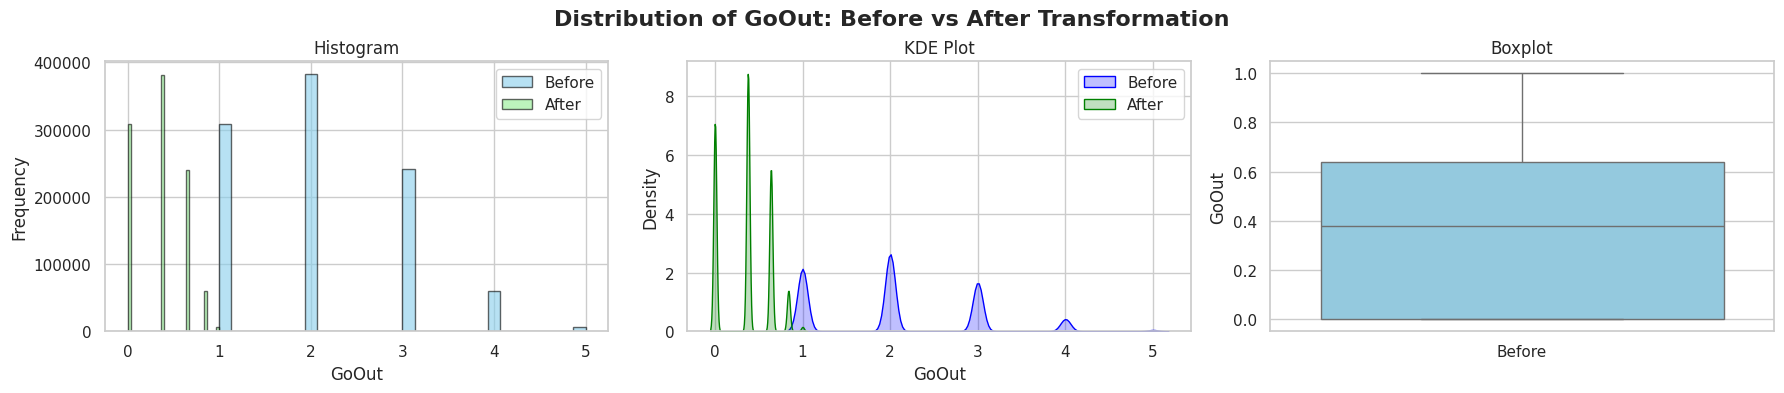

In [ ]:
# Load original dataset again
original_df = pd.read_csv('/content/test.csv')


# Define columns to exclude from continuous data analysis
excluded_cols = ['Grade', 'SES_Quartile', 'InternetAccess', 'Extracurricular', 'Romantic', 'PartTimeJob']

# Get continuous numeric columns only
numeric_cols = original_df.select_dtypes(include=[np.number]).columns
continuous_cols = [col for col in numeric_cols if col not in excluded_cols]

# Set plot style
sns.set(style="whitegrid")

# Loop through each continuous column
for col in continuous_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Distribution of {col}: Before vs After Transformation', fontsize=16, fontweight='bold')

    # ───── Histogram ─────
    axes[0].hist(original_df[col].dropna(), bins=30, alpha=0.6, label='Before', color='skyblue', edgecolor='black')
    axes[0].hist(dataset[col], bins=30, alpha=0.6, label='After', color='lightgreen', edgecolor='black')
    axes[0].set_title("Histogram")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    axes[0].grid(True)

    # ───── KDE Plot ─────
    sns.kdeplot(original_df[col].dropna(), ax=axes[1], label='Before', color='blue', fill=True)
    sns.kdeplot(dataset[col], ax=axes[1], label='After', color='green', fill=True)
    axes[1].set_title("KDE Plot")
    axes[1].set_xlabel(col)
    axes[1].legend()

    # ───── Boxplot ─────
    sns.boxplot(data=[original_df[col].dropna(), dataset[col]], ax=axes[2], palette=["skyblue", "lightgreen"])
    axes[2].set_xticklabels(["Before", "After"])
    axes[2].set_title("Boxplot")
    axes[2].set_ylabel(col)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Space for suptitle
    plt.show()

### 4.4.4 Additional Understanding (Data Visualization)

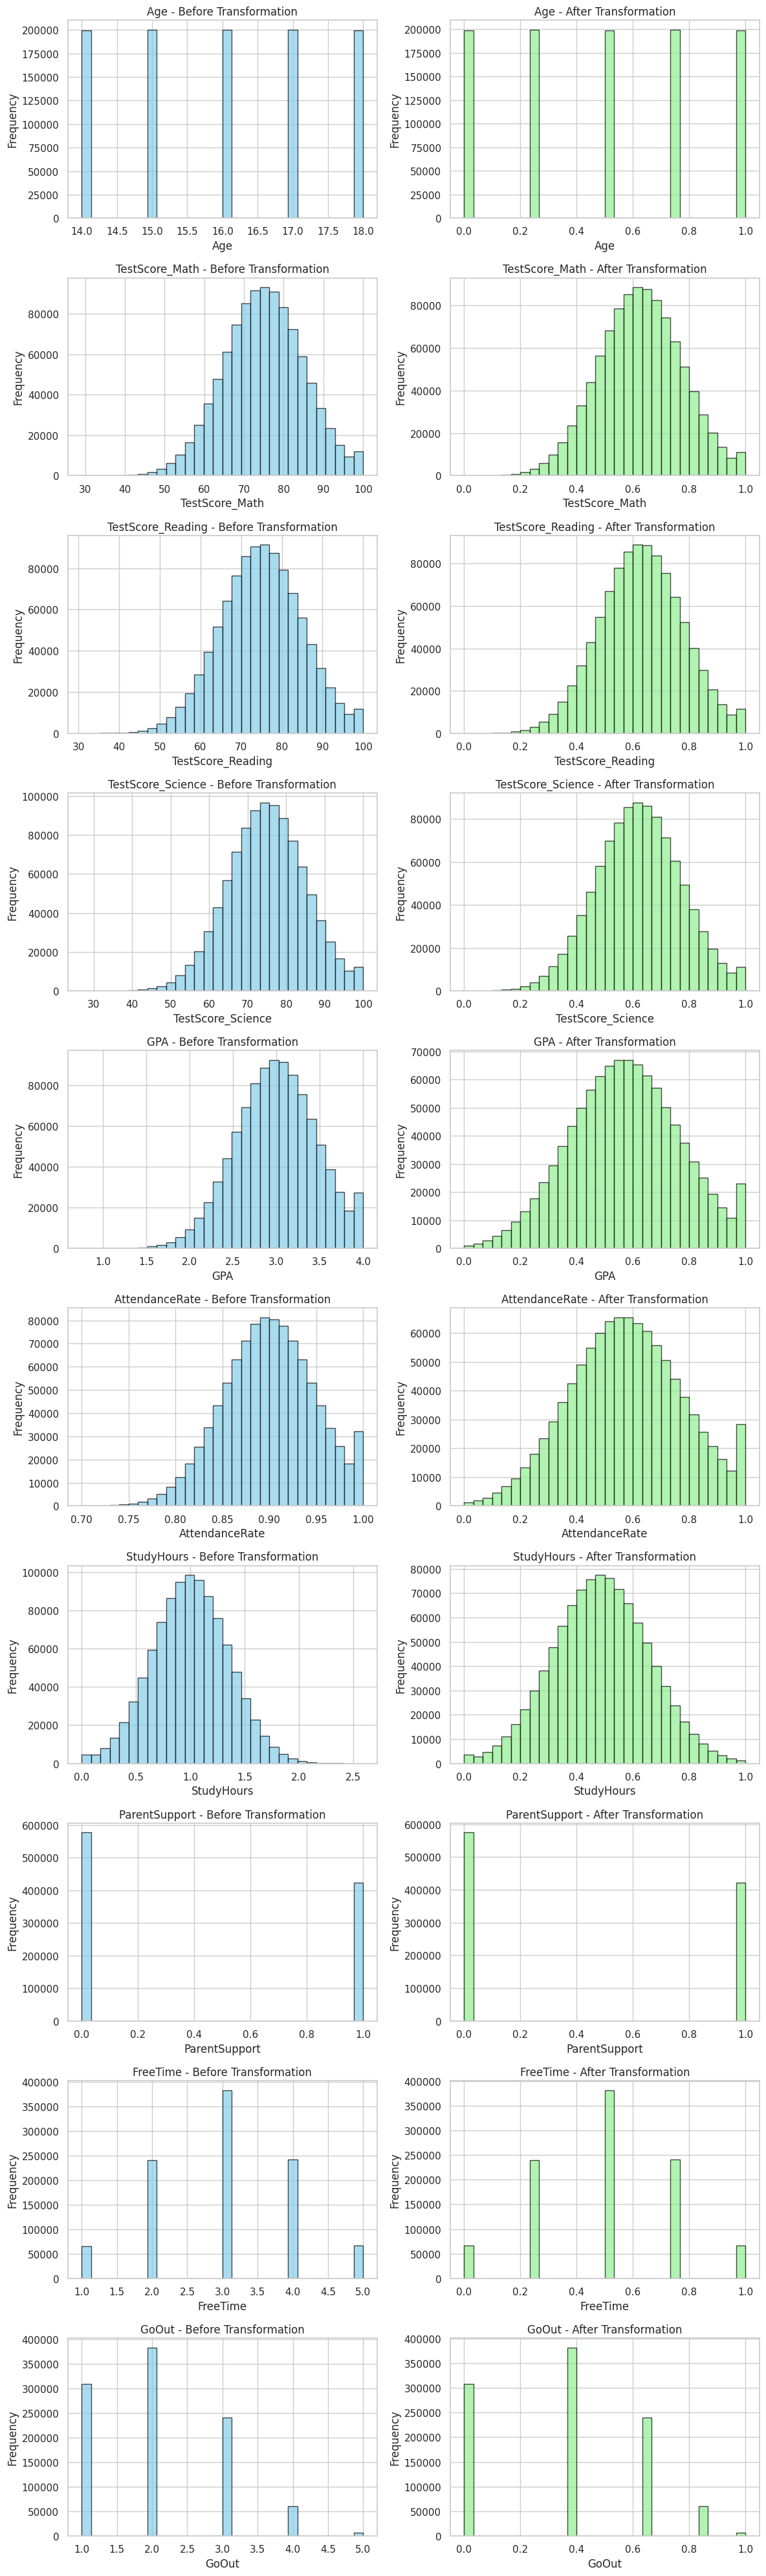

In [ ]:
# Data Visualization
# Load original dataset again (before transformation)
original_df = pd.read_csv('/content/test.csv')

# Select continuous numeric columns (exclude ordinal/binary)
numeric_cols = original_df.select_dtypes(include=[np.number]).columns
excluded_cols = ['Grade', 'SES_Quartile', 'InternetAccess', 'Extracurricular', 'Romantic', 'PartTimeJob']
continuous_cols = [col for col in numeric_cols if col not in excluded_cols]

# Set up the figure
fig, axes = plt.subplots(nrows=len(continuous_cols), ncols=2, figsize=(12, 4 * len(continuous_cols)))

# Plot original vs transformed for each feature
for idx, col in enumerate(continuous_cols):
    # Plot original
    axes[idx, 0].hist(original_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black', color='skyblue')
    axes[idx, 0].set_title(f'{col} - Before Transformation', fontsize=12)
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True)

    # Plot transformed
    axes[idx, 1].hist(dataset[col], bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
    axes[idx, 1].set_title(f'{col} - After Transformation', fontsize=12)
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True)

plt.tight_layout()
plt.show()

### 4.5 Model Building

In [14]:
X = dataset.drop(['Risk', 'GPA'], axis=1)
y = dataset['Risk']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("X_train:",len(X_train))
print("X_test:",len(X_test))
print("y_train:",len(y_train))
print("y_test:",len(y_test))

X_train: 697935
X_test: 149558
y_train: 697935
y_test: 149558


In [15]:
print(dataset['Risk'].value_counts())

Risk
0    856340
1    140711
Name: count, dtype: int64


In [16]:
print("\n==================== Logistic Regression ====================")

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_lg = logreg.predict(X_val)
y_proba_lg = logreg.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_lg))
print("Precision:", precision_score(y_val, y_pred_lg))
print("Recall:", recall_score(y_val, y_pred_lg))
print("F1 Score:", f1_score(y_val, y_pred_lg))
print("AUC:", roc_auc_score(y_val, y_proba_lg))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_lg))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_lg))



==================== Logistic Regression ====================
Accuracy: 0.8859372283662525
Precision: 0.6689969110713705
Recall: 0.38789649809115334
F1 Score: 0.4910647692353591
AUC: 0.8899812985220933

Confusion Matrix:
[[124269   4072]
 [ 12987   8230]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    128341
           1       0.67      0.39      0.49     21217

    accuracy                           0.89    149558
   macro avg       0.79      0.68      0.71    149558
weighted avg       0.87      0.89      0.87    149558



In [ ]:
print("\n==================== Random Forest ====================")

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Precision:", precision_score(y_val, y_pred_rf))
print("Recall:", recall_score(y_val, y_pred_rf))
print("F1 Score:", f1_score(y_val, y_pred_rf))
print("AUC:", roc_auc_score(y_val, y_proba_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))


==================== Random Forest ====================
Accuracy: 0.8848339774535632
Precision: 0.6701030927835051
Recall: 0.37069331196681904
F1 Score: 0.4773320385992596
AUC: 0.8844566056300801

Confusion Matrix:
[[124469   3872]
 [ 13352   7865]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94    128341
           1       0.67      0.37      0.48     21217

    accuracy                           0.88    149558
   macro avg       0.79      0.67      0.71    149558
weighted avg       0.87      0.88      0.87    149558



In [ ]:
print("\n==================== Gradient Boosting ====================")

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_val)
y_proba_gb = gb.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_gb))
print("Precision:", precision_score(y_val, y_pred_gb))
print("Recall:", recall_score(y_val, y_pred_gb))
print("F1 Score:", f1_score(y_val, y_pred_gb))
print("AUC:", roc_auc_score(y_val, y_proba_gb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_gb))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_gb))



==================== Gradient Boosting ====================
Accuracy: 0.8854290643094986
Precision: 0.6741764806280935
Recall: 0.372342932554084
F1 Score: 0.4797328070441779
AUC: 0.889494948301158

Confusion Matrix:
[[124523   3818]
 [ 13317   7900]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94    128341
           1       0.67      0.37      0.48     21217

    accuracy                           0.89    149558
   macro avg       0.79      0.67      0.71    149558
weighted avg       0.87      0.89      0.87    149558



### Choose Best Model

In [ ]:
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "AUC": []
}

def add_result(name, y_pred, y_proba):
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_val, y_pred))
    results["Precision"].append(precision_score(y_val, y_pred))
    results["Recall"].append(recall_score(y_val, y_pred))
    results["F1"].append(f1_score(y_val, y_pred))
    results["AUC"].append(roc_auc_score(y_val, y_proba))


add_result("Logistic Regression", y_pred_lg, y_proba_lg)
add_result("Random Forest", y_pred_rf, y_proba_rf)
add_result("Gradient Boosting", y_pred_gb, y_proba_gb)

df_results = pd.DataFrame(results)
print(df_results)


                 Model  Accuracy  Precision    Recall        F1       AUC
0  Logistic Regression  0.885937   0.668997  0.387896  0.491065  0.889981
1        Random Forest  0.884834   0.670103  0.370693  0.477332  0.884457
2    Gradient Boosting  0.885429   0.674176  0.372343  0.479733  0.889495


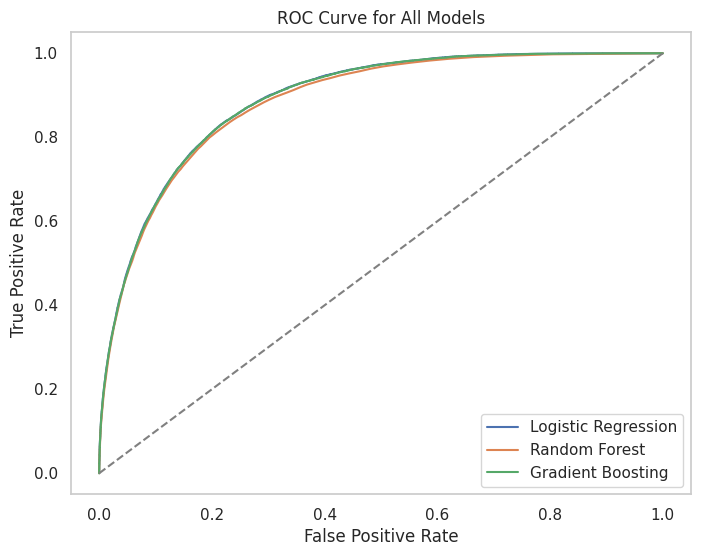

In [ ]:
plt.figure(figsize=(8,6))

models_proba = {
    "Logistic Regression": y_proba_lg,
    "Random Forest": y_proba_rf,
    "Gradient Boosting": y_proba_gb,
}

for name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_val, proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend()
plt.grid()
plt.show()

In [ ]:
best_model_name = df_results.sort_values('AUC', ascending=False).iloc[0]['Model']
print("Best Model:", best_model_name)

Best Model: Logistic Regression


### Load Model and Predict on New Student Data

In [ ]:
import joblib
import json

# best_model = logreg
best_model = logreg

# 1. save model
joblib.dump(best_model, "/content/best_risk_model.pkl")

# 2. save preprocessors
joblib.dump(pt, "/content/pt_transform.pkl")
joblib.dump(scaler, "/content/scaler_scaler.pkl")
joblib.dump(scaler_norm, "/content/scaler_norm.pkl")

# 3. save transform_cols list
transform_cols = continuous_cols.copy()
with open("/content/transform_cols.json", "w") as f:
    json.dump(transform_cols, f)

# 4. save final column order (VERY IMPORTANT!)
final_columns = list(X_train.columns)
with open("/content/final_columns.json", "w") as f:
    json.dump(final_columns, f)

print("✅ All deployment files saved!")

✅ All deployment files saved!


### MODEL TUNING

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        max_iter=2000,
        solver='liblinear'
    ))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
y_proba = pipe.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.8860709557496088


### PREDICTION

In [ ]:
import joblib
import json
import pandas as pd

# Load model & preprocessors
model = joblib.load("/content/best_risk_model.pkl")
pt = joblib.load("/content/pt_transform.pkl")
scaler = joblib.load("/content/scaler_scaler.pkl")
scaler_norm = joblib.load("/content/scaler_norm.pkl")

# Load transform column names
with open("/content/transform_cols.json","r") as f:
    transform_cols = json.load(f)

# Load final one-hot encoded column order
with open("/content/final_columns.json","r") as f:
    final_columns = json.load(f)


In [ ]:
new_student = pd.DataFrame([{
    "Age": 16,
    "Grade": 10,
    "Gender": "Female",
    "Race": "White",
    "ParentalEducation": "HS",
    "SchoolType": "Public",
    "Locale": "City",
    "TestScore_Math": 10.0,
    "TestScore_Reading": 10.0,
    "TestScore_Science": 10.0,
    "AttendanceRate": 0.88,
    "StudyHours": 1.0,
    "InternetAccess": 1,
    "Extracurricular": 0,
    "PartTimeJob": 0,
    "ParentSupport": 0.80,
    "Romantic": 0,
    "FreeTime": 3,
    "GoOut": 1
}])


In [ ]:
new_student_encoded = pd.get_dummies(new_student)

# Add missing columns
for col in final_columns:
    if col not in new_student_encoded:
        new_student_encoded[col] = 0

# Ensure SAME order as training
new_student_encoded = new_student_encoded[final_columns]

In [ ]:
new_student_encoded

,Age,Grade,SES_Quartile,TestScore_Math,TestScore_Reading,TestScore_Science,AttendanceRate,StudyHours,InternetAccess,Extracurricular,...,Race_Other,Race_Two-or-more,Race_White,ParentalEducation_Bachelors+,ParentalEducation_HS,ParentalEducation_SomeCollege,SchoolType_Public,Locale_Rural,Locale_Suburban,Locale_Town
0,16,10,0,10.0,10.0,10.0,0.88,1.0,1,0,...,0,0,True,0,True,0,True,0,0,0


In [ ]:
new_student_encoded[transform_cols] = pt.transform(new_student_encoded[transform_cols])
new_student_encoded[transform_cols] = scaler.transform(new_student_encoded[transform_cols])
new_student_encoded[transform_cols] = scaler_norm.transform(new_student_encoded[transform_cols])

In [ ]:
pred = model.predict(new_student_encoded)[0]
prob = model.predict_proba(new_student_encoded)[0][1]

print("Predicted Risk:", pred)
print("Probability:", prob)

if pred == 1:
    print(f"⚠️ High Risk ({prob*100:.2f}%)")
else:
    print(f"✅ Low Risk ({prob*100:.2f}%)")

Predicted Risk: 1
Probability: 0.9999959323356938
⚠️ High Risk (100.00%)


In [ ]:
transform_cols

['Age',
 'Grade',
 'SES_Quartile',
 'TestScore_Math',
 'TestScore_Reading',
 'TestScore_Science',
 'AttendanceRate',
 'StudyHours',
 'ParentSupport',
 'FreeTime',
 'GoOut']